Importation des bibliothèques nécessaires

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import joblib



Chargement des données

In [2]:
# Chargement des données
df = pd.read_csv("/content/drive/My Drive/youtube_comments_with_sentiments.csv")

# Affichage des informations de base
print(df.info())
print(df['Sentiment'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17895 entries, 0 to 17894
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Video ID         17895 non-null  object
 1   Video Title      17895 non-null  object
 2   Comment          17895 non-null  object
 3   Cleaned_Comment  17894 non-null  object
 4   Sentiment        17895 non-null  object
dtypes: object(5)
memory usage: 699.2+ KB
None
Sentiment
Positif    10429
Négatif     4882
Neutre      2584
Name: count, dtype: int64


Nettoyage et prétraitement des données

In [3]:
!pip install spacy
!python -m spacy download fr_core_news_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 18.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [4]:
import spacy
import re
import nltk
from nltk.corpus import stopwords

# Télécharger les stopwords si ce n'est pas encore fait
nltk.download('stopwords')

# Charger le modèle de spaCy pour le français
nlp = spacy.load("fr_core_news_sm")

# Nettoyage des commentaires
def clean_text(text):
    # Suppression des caractères spéciaux et des chiffres
    text = re.sub(r'[^a-zA-ZÀ-ÿ\s]', '', text, re.I | re.A)
    # Conversion en minuscules
    text = text.lower()

    # Tokenisation et lemmatisation avec spaCy
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc]

    # Suppression des stopwords en français
    stop_words = set(stopwords.words('french'))
    tokens = [word for word in tokens if word not in stop_words]

    # Reconstitution du texte nettoyé
    return ' '.join(tokens)

# Appliquer la fonction de nettoyage à la colonne 'Comment'
df['Cleaned_Comment'] = df['Comment'].apply(clean_text)

# Affichage des premières lignes
print(df.head())


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


      Video ID                              Video Title  \
0  J1Z1A46FknM  QUI EST L'IMPOSTEUR ? (ft Eric & Ramzy)   
1  J1Z1A46FknM  QUI EST L'IMPOSTEUR ? (ft Eric & Ramzy)   
2  J1Z1A46FknM  QUI EST L'IMPOSTEUR ? (ft Eric & Ramzy)   
3  J1Z1A46FknM  QUI EST L'IMPOSTEUR ? (ft Eric & Ramzy)   
4  J1Z1A46FknM  QUI EST L'IMPOSTEUR ? (ft Eric & Ramzy)   

                                             Comment  \
0  Mais Eric et Ramzy, quand ils partent dans leu...   
1  La meilleure vidéo de squezzy <a href="https:/...   
2  A <a href="https://www.youtube.com/watch?v=J1Z...   
3           Coucou du coup Éric il a eu 50 000 quoi?   
4  Chaque année je me refais cet épisode et j&#39...   

                                     Cleaned_Comment Sentiment  
0  eric ramzy quand partir délire être inarrêtabl...    Neutre  
1  meilleur vidéo squezzy avoir hrefhttpswwwyoutu...   Positif  
2  avoir avoir hrefhttpswwwyoutubecomwatchvjzafkn...   Négatif  
3               coucou coup éric avoir avoir    

In [5]:
df

,Video ID,Video Title,Comment,Cleaned_Comment,Sentiment
0,J1Z1A46FknM,QUI EST L'IMPOSTEUR ? (ft Eric & Ramzy),"Mais Eric et Ramzy, quand ils partent dans leu...",eric ramzy quand partir délire être inarrêtabl...,Neutre
1,J1Z1A46FknM,QUI EST L'IMPOSTEUR ? (ft Eric & Ramzy),"La meilleure vidéo de squezzy <a href=""https:/...",meilleur vidéo squezzy avoir hrefhttpswwwyoutu...,Positif
2,J1Z1A46FknM,QUI EST L'IMPOSTEUR ? (ft Eric & Ramzy),"A <a href=""https://www.youtube.com/watch?v=J1Z...",avoir avoir hrefhttpswwwyoutubecomwatchvjzafkn...,Négatif
3,J1Z1A46FknM,QUI EST L'IMPOSTEUR ? (ft Eric & Ramzy),Coucou du coup Éric il a eu 50 000 quoi?,coucou coup éric avoir avoir quoi,Négatif
4,J1Z1A46FknM,QUI EST L'IMPOSTEUR ? (ft Eric & Ramzy),Chaque année je me refais cet épisode et j&#39...,chaque année refaire épisode jen rigol toujour...,Positif
...,...,...,...,...,...
17890,J1Z1A46FknM,QUI EST L'IMPOSTEUR ? (ft Eric & Ramzy),"J’attend toujours cette vidéo avec impatience,...",jattend toujours vidéo impatience vouloir séri...,Positif
17891,J1Z1A46FknM,QUI EST L'IMPOSTEUR ? (ft Eric & Ramzy),Il faut un autre episode,falloir autre episode,Neutre
17892,J1Z1A46FknM,QUI EST L'IMPOSTEUR ? (ft Eric & Ramzy),La notification qui fait plaisir 😁,notification faire plaisir,Positif
17893,J1Z1A46FknM,QUI EST L'IMPOSTEUR ? (ft Eric & Ramzy),Les meilleurs invités au monde j&#39;ai jurée ...,meilleur inviter monde jai jurer excellent vid...,Positif


In [6]:
# Encodage des sentiments
label_encoder = LabelEncoder()
df['Sentiment'] = label_encoder.fit_transform(df['Sentiment'])

In [7]:
label_encoder_path = "/content/drive/My Drive/label_encoder.pkl"
joblib.dump(label_encoder, label_encoder_path)
print("Sauvegarde terminée !")

Sauvegarde terminée !


In [ ]:
df

,Video ID,Video Title,Comment,Cleaned_Comment,Sentiment
0,J1Z1A46FknM,QUI EST L'IMPOSTEUR ? (ft Eric & Ramzy),"Mais Eric et Ramzy, quand ils partent dans leu...",eric ramzy quand partir délire être inarrêtabl...,0
1,J1Z1A46FknM,QUI EST L'IMPOSTEUR ? (ft Eric & Ramzy),"La meilleure vidéo de squezzy <a href=""https:/...",meilleur vidéo squezzy avoir hrefhttpswwwyoutu...,2
2,J1Z1A46FknM,QUI EST L'IMPOSTEUR ? (ft Eric & Ramzy),"A <a href=""https://www.youtube.com/watch?v=J1Z...",avoir avoir hrefhttpswwwyoutubecomwatchvjzafkn...,1
3,J1Z1A46FknM,QUI EST L'IMPOSTEUR ? (ft Eric & Ramzy),Coucou du coup Éric il a eu 50 000 quoi?,coucou coup éric avoir avoir quoi,1
4,J1Z1A46FknM,QUI EST L'IMPOSTEUR ? (ft Eric & Ramzy),Chaque année je me refais cet épisode et j&#39...,chaque année refaire épisode jen rigol toujour...,2
...,...,...,...,...,...
17890,J1Z1A46FknM,QUI EST L'IMPOSTEUR ? (ft Eric & Ramzy),"J’attend toujours cette vidéo avec impatience,...",jattend toujours vidéo impatience vouloir séri...,2
17891,J1Z1A46FknM,QUI EST L'IMPOSTEUR ? (ft Eric & Ramzy),Il faut un autre episode,falloir autre episode,0
17892,J1Z1A46FknM,QUI EST L'IMPOSTEUR ? (ft Eric & Ramzy),La notification qui fait plaisir 😁,notification faire plaisir,2
17893,J1Z1A46FknM,QUI EST L'IMPOSTEUR ? (ft Eric & Ramzy),Les meilleurs invités au monde j&#39;ai jurée ...,meilleur inviter monde jai jurer excellent vid...,2


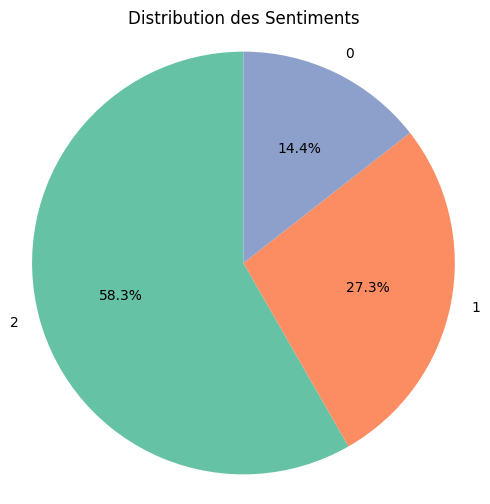

Nombre de sentiments pour chaque catégorie:
Sentiment
2    10429
1     4882
0     2584
Name: count, dtype: int64


In [ ]:
# Calcul des valeurs de sentiment
sentiment_counts = df['Sentiment'].value_counts()

# Affichage des sentiments sous forme de graphique circulaire
plt.figure(figsize=(6, 6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Set2", len(sentiment_counts)))
plt.title('Distribution des Sentiments')
plt.axis('equal')  # Pour un cercle parfait
plt.show()

# Affichage des valeurs des sentiments sous forme de nombre
print("Nombre de sentiments pour chaque catégorie:")
print(sentiment_counts)


Division des données

In [8]:
# Séparation des features et de la target
X = df['Cleaned_Comment']
y = df['Sentiment']

# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Vectorisation des textes

In [9]:
# Utilisation de TfidfVectorizer pour convertir le texte en vecteurs
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [10]:
tfidf_path = "/content/drive/My Drive/tfidf_vectorizer.pkl"
joblib.dump(tfidf, tfidf_path)
print("Sauvegarde terminée !")

Sauvegarde terminée !


Gestion du déséquilibre des classes

In [11]:
from imblearn.over_sampling import SMOTE

# Application de SMOTE pour équilibrer les classes
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_tfidf, y_train)

# Vérification de la distribution des classes après SMOTE
print(pd.Series(y_train_res).value_counts())

Sentiment
0    8371
2    8371
1    8371
Name: count, dtype: int64


modèle Linear SVC

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Initialisation du modèle Linear SVC
linear_svc = LinearSVC(random_state=42)

# Entraînement du modèle sur les données rééquilibrées
linear_svc.fit(X_train_res, y_train_res)



LinearSVC(random_state=42)

In [ ]:
# Prédiction sur l'ensemble de test
y_pred = linear_svc.predict(X_test_tfidf)



In [ ]:
# Calcul de l'accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Linear SVC Accuracy: {accuracy}")


Linear SVC Accuracy: 0.6999161777032691


In [ ]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.37      0.52      0.43       506
           1       0.63      0.66      0.64       958
           2       0.86      0.76      0.81      2115

    accuracy                           0.70      3579
   macro avg       0.62      0.65      0.63      3579
weighted avg       0.73      0.70      0.71      3579



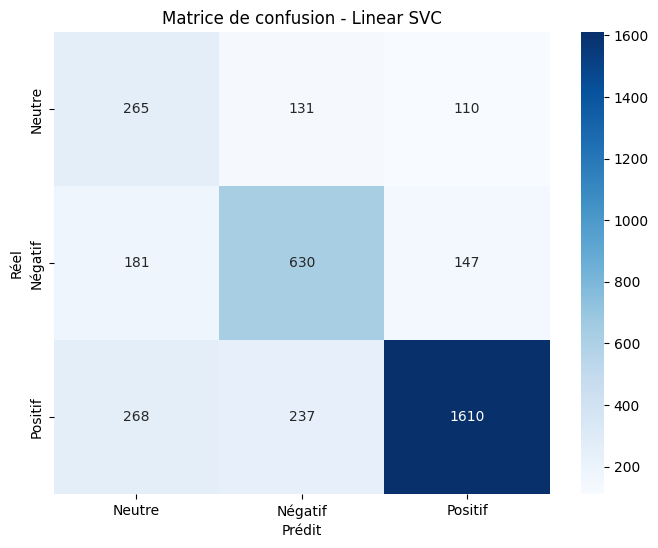

In [ ]:

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Matrice de confusion - Linear SVC')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.show()


In [ ]:
# Validation croisée
cv_scores = cross_val_score(linear_svc, X_train_res, y_train_res, cv=5, scoring='accuracy')
print(f"Linear SVC Cross-Validation Scores: {cv_scores}")
print(f"Linear SVC Mean CV Accuracy: {cv_scores.mean()}")

Linear SVC Cross-Validation Scores: [0.76643945 0.78688853 0.79831596 0.7840818  0.79727291]
Linear SVC Mean CV Accuracy: 0.7865997302690284


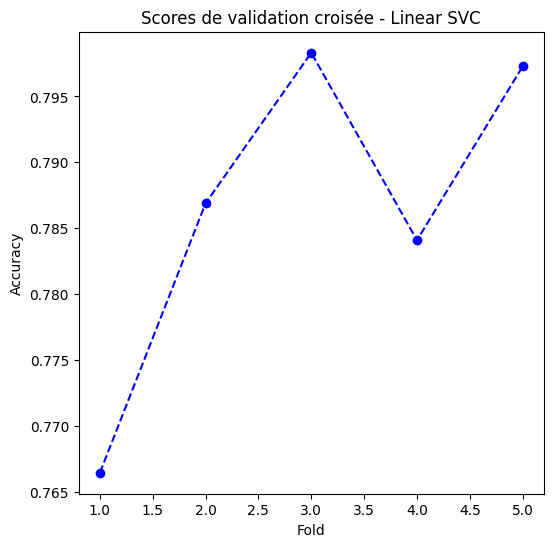

In [ ]:
# Visualisation des scores de validation croisée
plt.figure(figsize=(6, 6))
plt.plot(range(1, 6), cv_scores, marker='o', linestyle='--', color='b')
plt.title('Scores de validation croisée - Linear SVC')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
from sklearn.model_selection import cross_val_predict
# Prédictions via validation croisée
y_pred_cv = cross_val_predict(linear_svc, X_train_res, y_train_res, cv=5)

# Affichage du rapport de classification sur les prédictions
print("Classification Report (Validation Croisée sur Train Data):")
print(classification_report(y_train_res, y_pred_cv))

Classification Report (Validation Croisée sur Train Data):
              precision    recall  f1-score   support

           0       0.73      0.88      0.80      8313
           1       0.80      0.72      0.75      8313
           2       0.86      0.76      0.81      8313

    accuracy                           0.79     24939
   macro avg       0.79      0.79      0.79     24939
weighted avg       0.79      0.79      0.79     24939



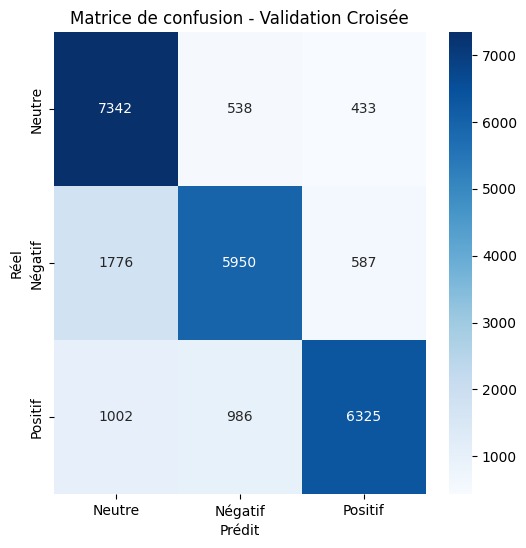

In [ ]:
# Matrice de confusion sur les prédictions de validation croisée
conf_matrix_cv = confusion_matrix(y_train_res, y_pred_cv)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_cv, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Matrice de confusion - Validation Croisée')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.show()

In [ ]:
# Sauvegarde du modèle
joblib.dump(linear_svc, "/content/drive/My Drive/linear_svc_model.pkl")

['/content/drive/My Drive/linear_svc_model.pkl']

Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

# Initialisation du modèle Logistic Regression
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# Entraînement du modèle sur les données rééquilibrées
log_reg.fit(X_train_res, y_train_res)

# Prédiction sur l'ensemble de test
y_pred = log_reg.predict(X_test_tfidf)

# Calcul de l'accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Logistic Regression Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))



Logistic Regression Accuracy: 0.6932103939647947
              precision    recall  f1-score   support

           0       0.36      0.55      0.43       506
           1       0.63      0.67      0.65       958
           2       0.87      0.74      0.80      2115

    accuracy                           0.69      3579
   macro avg       0.62      0.65      0.63      3579
weighted avg       0.74      0.69      0.71      3579



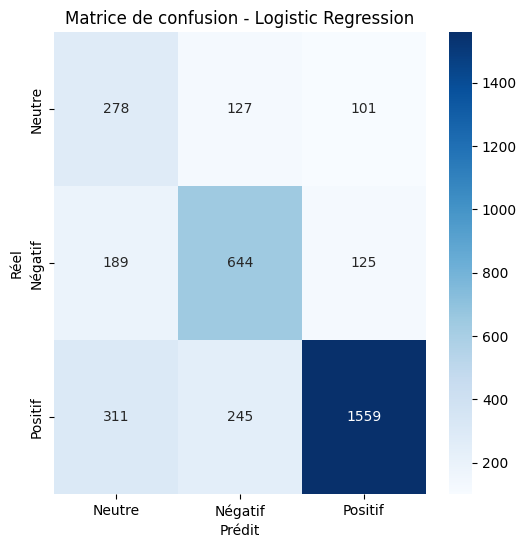

In [ ]:
# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Matrice de confusion - Logistic Regression')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.show()



In [ ]:
# Validation croisée
cv_scores = cross_val_score(log_reg, X_train_res, y_train_res, cv=5, scoring='accuracy')
print(f"Logistic Regression Cross-Validation Scores: {cv_scores}")
print(f"Logistic Regression Mean CV Accuracy: {cv_scores.mean()}")



Logistic Regression Cross-Validation Scores: [0.72955092 0.76663994 0.76924619 0.75140337 0.76438741]
Logistic Regression Mean CV Accuracy: 0.7562455648519351


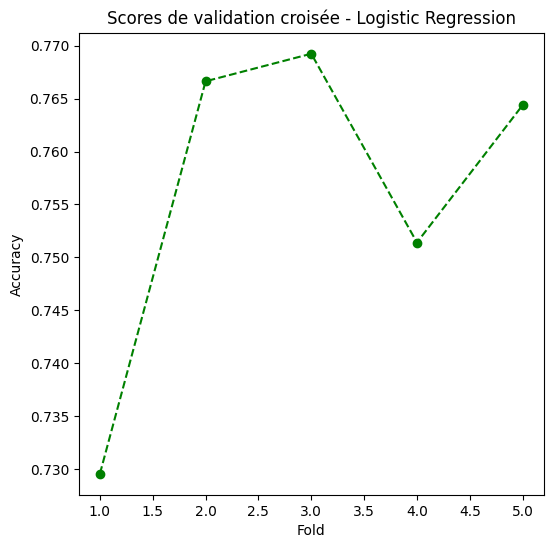

In [ ]:
# Visualisation des scores de validation croisée
plt.figure(figsize=(6, 6))
plt.plot(range(1, 6), cv_scores, marker='o', linestyle='--', color='g')
plt.title('Scores de validation croisée - Logistic Regression')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.show()



In [ ]:
# Sauvegarde du modèle
joblib.dump(log_reg, "/content/drive/My Drive/log_reg_model.pkl")

['/content/drive/My Drive/log_reg_model.pkl']

Multinomial Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB

# Initialisation du modèle Multinomial Naive Bayes
mnb = MultinomialNB()

# Entraînement du modèle sur les données rééquilibrées
mnb.fit(X_train_res, y_train_res)

# Prédiction sur l'ensemble de test
y_pred = mnb.predict(X_test_tfidf)

# Calcul de l'accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Multinomial Naive Bayes Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

Multinomial Naive Bayes Accuracy: 0.6677842972897458
              precision    recall  f1-score   support

           0       0.34      0.53      0.42       506
           1       0.60      0.59      0.60       958
           2       0.84      0.74      0.78      2115

    accuracy                           0.67      3579
   macro avg       0.59      0.62      0.60      3579
weighted avg       0.71      0.67      0.68      3579



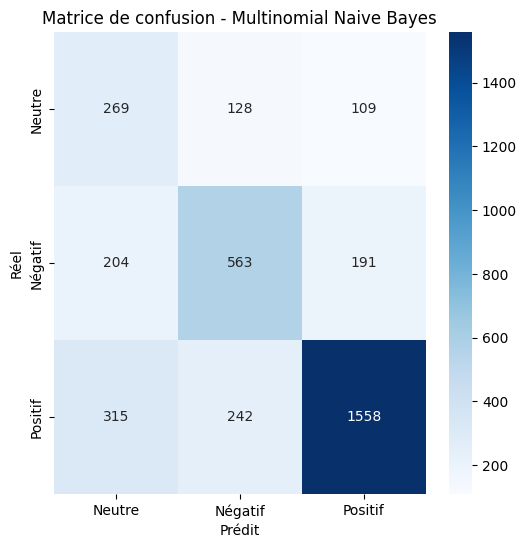

In [ ]:
# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Matrice de confusion - Multinomial Naive Bayes')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.show()

In [ ]:
# Validation croisée
cv_scores = cross_val_score(mnb, X_train_res, y_train_res, cv=5, scoring='accuracy')
print(f"Multinomial Naive Bayes Cross-Validation Scores: {cv_scores}")
print(f"Multinomial Naive Bayes Mean CV Accuracy: {cv_scores.mean()}")

Multinomial Naive Bayes Cross-Validation Scores: [0.70829992 0.7085004  0.72373697 0.73757017 0.7633848 ]
Multinomial Naive Bayes Mean CV Accuracy: 0.7282984516760418


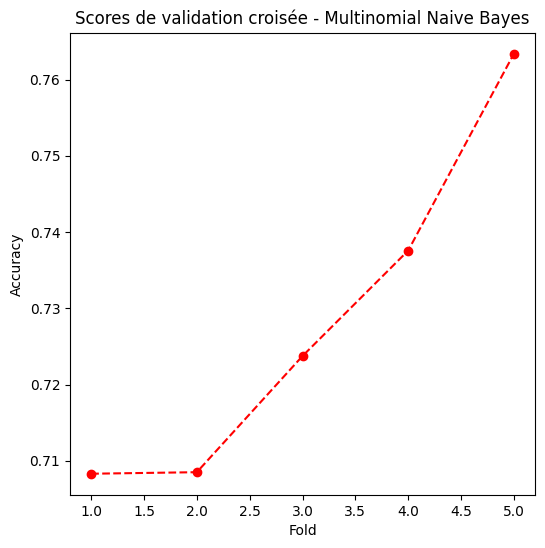

In [ ]:
# Visualisation des scores de validation croisée
plt.figure(figsize=(6, 6))
plt.plot(range(1, 6), cv_scores, marker='o', linestyle='--', color='r')
plt.title('Scores de validation croisée - Multinomial Naive Bayes')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
# Sauvegarde du modèle
joblib.dump(mnb, "/content/drive/My Drive/mnb_model.pkl")

['/content/drive/My Drive/mnb_model.pkl']

Random Forest

In [12]:
from sklearn.ensemble import RandomForestClassifier

# Initialisation du modèle Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Entraînement du modèle sur les données rééquilibrées
rf.fit(X_train_res, y_train_res)

# Prédiction sur l'ensemble de test
y_pred = rf.predict(X_test_tfidf)

# Calcul de l'accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

Random Forest Accuracy: 0.679519418832076
              precision    recall  f1-score   support

           0       0.38      0.40      0.39       518
           1       0.61      0.59      0.60      1003
           2       0.79      0.80      0.79      2058

    accuracy                           0.68      3579
   macro avg       0.59      0.59      0.59      3579
weighted avg       0.68      0.68      0.68      3579



In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Initialisation du modèle Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Entraînement du modèle sur les données rééquilibrées
rf.fit(X_train_res, y_train_res)

# Prédiction sur l'ensemble de test
y_pred = rf.predict(X_test_tfidf)

# Calcul de l'accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

Random Forest Accuracy: 0.6884604638167086
              precision    recall  f1-score   support

           0       0.36      0.41      0.38       506
           1       0.62      0.60      0.61       958
           2       0.81      0.80      0.80      2115

    accuracy                           0.69      3579
   macro avg       0.60      0.60      0.60      3579
weighted avg       0.70      0.69      0.69      3579



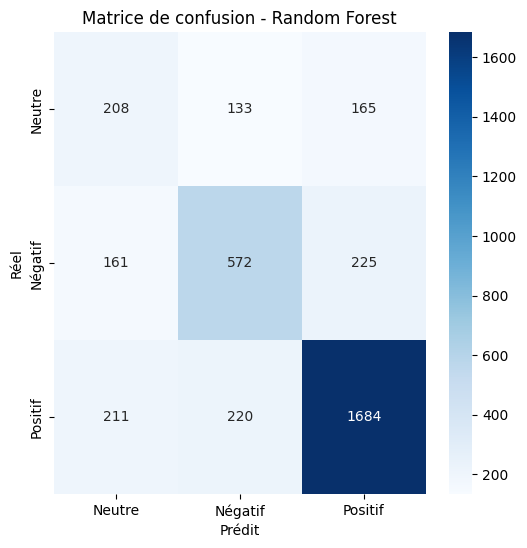

In [ ]:
# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Matrice de confusion - Random Forest')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.show()

In [ ]:
# Validation croisée
cv_scores = cross_val_score(rf, X_train_res, y_train_res, cv=5, scoring='accuracy')
print(f"Random Forest Cross-Validation Scores: {cv_scores}")
print(f"Random Forest Mean CV Accuracy: {cv_scores.mean()}")

Random Forest Cross-Validation Scores: [0.7882919  0.81655974 0.85244587 0.84482759 0.8526168 ]
Random Forest Mean CV Accuracy: 0.8309483807860338


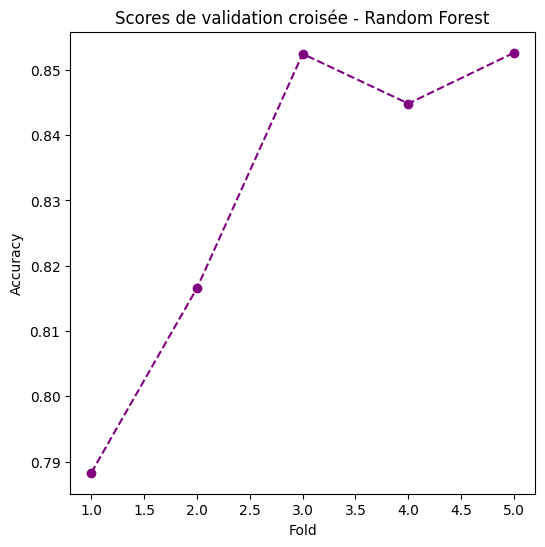

In [ ]:
# Visualisation des scores de validation croisée
plt.figure(figsize=(6, 6))
plt.plot(range(1, 6), cv_scores, marker='o', linestyle='--', color='purple')
plt.title('Scores de validation croisée - Random Forest')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
# Sauvegarde du modèle
joblib.dump(rf, "/content/drive/My Drive/rf_model.pkl")

['/content/drive/My Drive/rf_model.pkl']

Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Initialisation du modèle Decision Tree
dt = DecisionTreeClassifier(random_state=42)

# Entraînement du modèle sur les données rééquilibrées
dt.fit(X_train_res, y_train_res)

# Prédiction sur l'ensemble de test
y_pred = dt.predict(X_test_tfidf)

# Calcul de l'accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Decision Tree Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

Decision Tree Accuracy: 0.6303436714165969
              precision    recall  f1-score   support

           0       0.30      0.37      0.33       506
           1       0.53      0.54      0.54       958
           2       0.78      0.73      0.76      2115

    accuracy                           0.63      3579
   macro avg       0.54      0.55      0.54      3579
weighted avg       0.65      0.63      0.64      3579



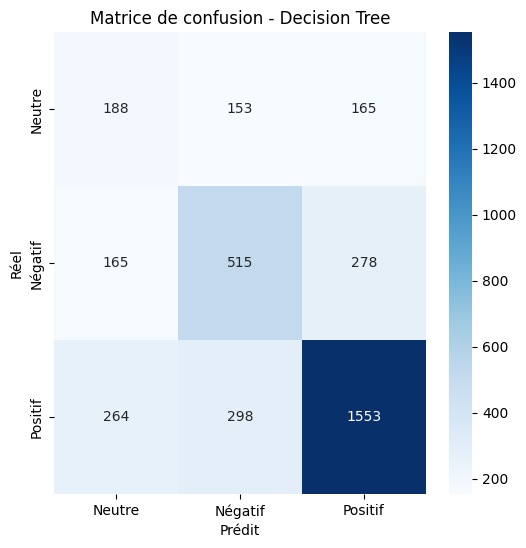

In [ ]:
# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Matrice de confusion - Decision Tree')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.show()

In [ ]:
# Validation croisée
cv_scores = cross_val_score(dt, X_train_res, y_train_res, cv=5, scoring='accuracy')
print(f"Decision Tree Cross-Validation Scores: {cv_scores}")
print(f"Decision Tree Mean CV Accuracy: {cv_scores.mean()}")

Decision Tree Cross-Validation Scores: [0.67782678 0.72594226 0.77526063 0.77546111 0.79045518]
Decision Tree Mean CV Accuracy: 0.7489891922687841


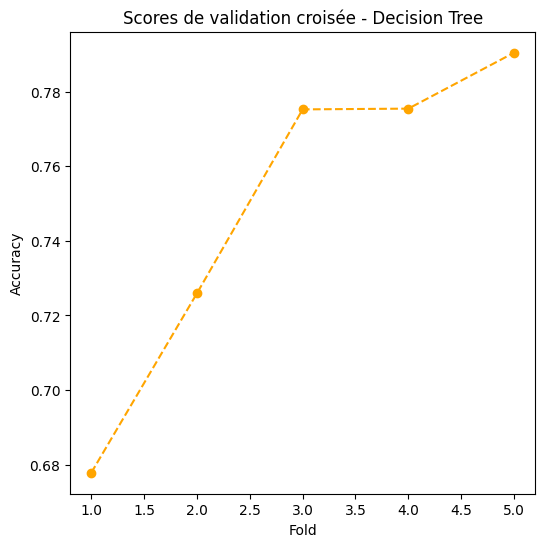

In [ ]:
# Visualisation des scores de validation croisée
plt.figure(figsize=(6, 6))
plt.plot(range(1, 6), cv_scores, marker='o', linestyle='--', color='orange')
plt.title('Scores de validation croisée - Decision Tree')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
# Sauvegarde du modèle
joblib.dump(dt, "/content/drive/My Drive/dt_model.pkl")

['/content/drive/My Drive/dt_model.pkl']

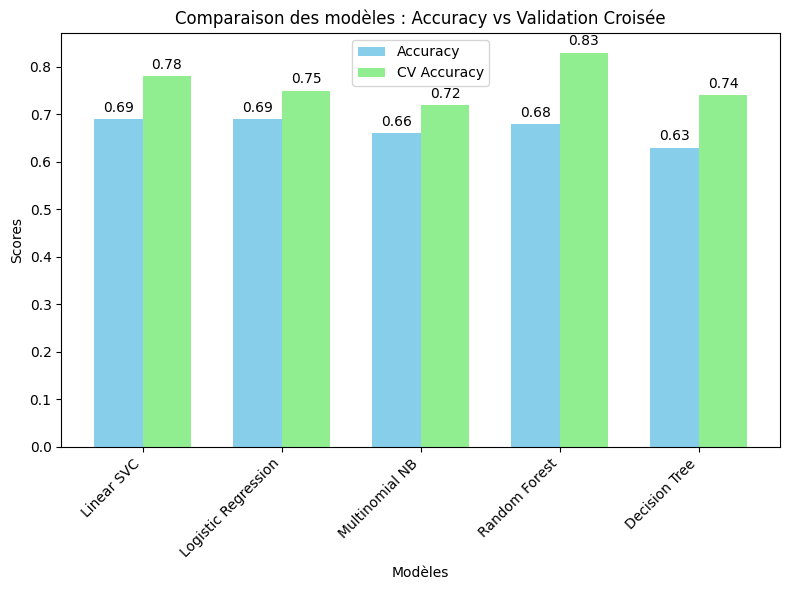

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Résultats d'accuracy et de validation croisée pour chaque modèle
models = ['Linear SVC', 'Logistic Regression', 'Multinomial NB', 'Random Forest', 'Decision Tree']
accuracy_scores = [0.69, 0.69, 0.66, 0.68, 0.63]
cv_scores = [0.78, 0.75, 0.72, 0.83,   0.74]

# Position des barres sur l'axe x
x = np.arange(len(models))

# Largeur des barres
width = 0.35

# Création du graphique
fig, ax = plt.subplots(figsize=(8, 6))

# Barres pour les accuracy scores
rects1 = ax.bar(x - width/2, accuracy_scores, width, label='Accuracy', color='skyblue')

# Barres pour les CV scores
rects2 = ax.bar(x + width/2, cv_scores, width, label='CV Accuracy', color='lightgreen')

# Ajout des labels, titres et légendes
ax.set_xlabel('Modèles')
ax.set_ylabel('Scores')
ax.set_title('Comparaison des modèles : Accuracy vs Validation Croisée')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha='right')
ax.legend()

# Ajout des valeurs sur les barres
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # Décalage vertical
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

# Ajustement de la mise en page
fig.tight_layout()

# Affichage du graphique
plt.show()